In [13]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from scipy import stats 
from scipy.stats import normaltest
import pickle
from collections import defaultdict
# 假设 rounds_data 是你已经有的数据
# rounds_data = # 你的rounds_data数据
rounds_data = []
iids = ["alpha_1", "alpha_0.1", "alpha_0.01"]
# pd = defaultdict(list)
pd,cd={},{}
try:
    for iid in iids:
        period_drift = defaultdict(list)
        client_drift = defaultdict(list)
        with open("femnist_lenet5_{}.pkl".format(iid), "rb") as file:
            while True:
                try:
                    data = pickle.load(file)
                    for k in data["grad_g"].keys():
                        period_drift[k].append(data["grad_s"][k].cpu() - data["grad_g"][k].cpu())
                        client_drift[k].append(data["grad_t"][k].cpu()*10 - data["grad_s"][k].cpu())
                except EOFError:
                    break
        pd[iid] = period_drift
        cd[iid] = client_drift
except FileNotFoundError:
    print("File not found.")

# try:
#     with open("femnist_cnnfemnist_alpha_1.pkl", "rb") as file:
#         while True:
#             try:
#                 data = pickle.load(file)
#                 rounds_data.append(data)
#             except EOFError:
#                 break
# except FileNotFoundError:
#     print("File not found.")

# for data in rounds_data:
#     for k in data["grad_g"].keys():
#         period_drift[k].append(data["grad_s"][k].cpu() - data["grad_g"][k].cpu())
#         client_drift[k].append(data["grad_t"][k].cpu() - data["grad_s"][k].cpu())

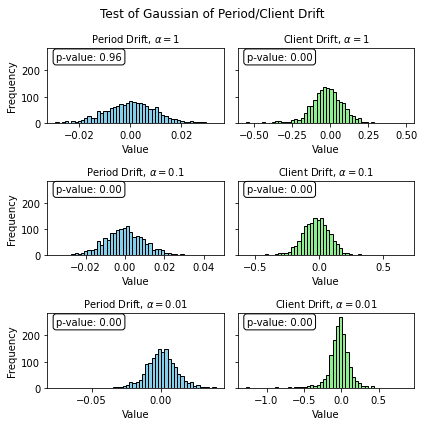

In [15]:
# 创建图表和轴对象
fig, axs = plt.subplots(3, 2, sharey=True, tight_layout=True, figsize=(6, 6))
fig.suptitle("Test of Gaussian of Period/Client Drift", fontsize=12)
alpha_values=[1,0.1,0.01]
for k in range(len(iids)):
    period_drift = pd[iids[k]]
    client_drift = cd[iids[k]]
    n_bins = 50

    dist1 = []
    dist2 = []
    i = 0
    # 多轮参数
    # 遍历state_dict中的每个参数，并将它们展平
    layers = list(period_drift.keys())
    layer = layers[0]
    for r in range(len(period_drift[layer])):
        # 使用.view(-1)将每个参数展平为一维向量
        # 将展平的参数添加到列表中
        dist1.append(period_drift[layer][r].flatten()[i].item())
        dist2.append(client_drift[layer][r].flatten()[i].item())

    # dist1=np.array(dist1)
    # mean_a = np.mean(dist1)
    # std_a = np.std(dist1)
    # z_scores = (dist1 - mean_a) / std_a
    # not_outliers = np.abs(z_scores) < 3
    # dist1 = dist1[not_outliers]

    # dist2=np.array(dist2)
    # mean_a = np.mean(dist2)
    # std_a = np.std(dist2)
    # z_scores = (dist2 - mean_a) / std_a
    # not_outliers = np.abs(z_scores) < 2.3
    # dist2 = dist2[not_outliers]

    # 直方图1
    a0 = axs[k][0].hist(dist1, bins=n_bins, color="skyblue", edgecolor="black")
    axs[k][0].set_title(r"Period Drift, $\alpha={}$".format(alpha_values[k]), fontsize=10)
    axs[k][0].set_xlabel("Value")
    axs[k][0].set_ylabel("Frequency")

    # 直方图2
    a1 = axs[k][1].hist(dist2, bins=n_bins, color="lightgreen", edgecolor="black")
    axs[k][1].set_title(r"Client Drift, $\alpha={}$".format(alpha_values[k]), fontsize=10)
    axs[k][1].set_xlabel("Value")

    # 将横坐标的0放在中间位置
    for ax in axs[k]:
        # ax.spines["top"].set_visible(False)
        # ax.spines["right"].set_visible(False)
        ax.spines["bottom"].set_position(("data", 0))
        # ax.spines["left"].set_smart_bounds(True)
        # ax.xaxis.set_ticks_position("bottom")
        # ax.yaxis.set_ticks_position("left")

    # 正态性测试
    # r=100
    # dist1 = dist1[:r]
    # dist2 = dist2[:r]
    stat1, p_period = normaltest(dist1)
    stat2, p_client = normaltest(dist2)

    # 添加正态性测试结果
    axs[k][0].annotate(
        f"p-value: {p_period:.2f}",
        xy=(0.05, 0.95),
        xycoords="axes fraction",
        ha="left",
        va="top",
        bbox=dict(boxstyle="round", fc="white"),
    )
    axs[k][1].annotate(
        f"p-value: {p_client:.2f}",
        xy=(0.05, 0.95),
        xycoords="axes fraction",
        ha="left",
        va="top",
        bbox=dict(boxstyle="round", fc="white"),
    )
fig.savefig("gaussian.pdf", bbox_inches="tight")
plt.show()

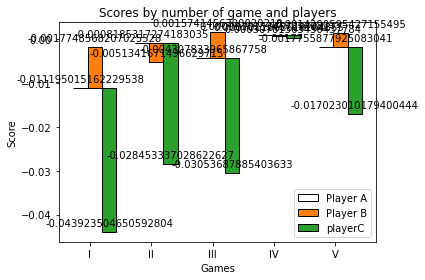

In [15]:
import matplotlib.pyplot as plt
import numpy as np


def hat_graph(ax, xlabels, values, group_labels):
    """
    Create a hat graph.

    Parameters
    ----------
    ax : matplotlib.axes.Axes
        The Axes to plot into.
    xlabels : list of str
        The category names to be displayed on the x-axis.
    values : (M, N) array-like
        The data values.
        Rows are the groups (len(group_labels) == M).
        Columns are the categories (len(xlabels) == N).
    group_labels : list of str
        The group labels displayed in the legend.
    """

    def label_bars(heights, rects):
        """Attach a text label on top of each bar."""
        for height, rect in zip(heights, rects):
            ax.annotate(
                f"{height}",
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 4),  # 4 points vertical offset.
                textcoords="offset points",
                ha="center",
                va="bottom",
            )

    values = np.asarray(values)
    x = np.arange(values.shape[1])
    ax.set_xticks(x, labels=xlabels)
    spacing = 0.3  # spacing between hat groups
    width = (1 - spacing) / values.shape[0]
    heights0 = values[0]
    for i, (heights, group_label) in enumerate(zip(values, group_labels)):
        style = {"fill": False} if i == 0 else {"edgecolor": "black"}
        rects = ax.bar(
            x - spacing / 2 + i * width,
            heights - heights0,
            width,
            bottom=heights0,
            label=group_label,
            **style,
        )
        label_bars(heights, rects)


# initialise labels and a numpy array make sure you have
# N labels of N number of values in the array
xlabels = ["I", "II", "III", "IV", "V"]
playerA = np.array(data["grad_g"]["fc2.bias"].cpu().flatten()[:5])
playerB = np.array(pd["alpha_0.01"]["fc2.bias"][-1].cpu().flatten()[:5])
playerC = np.array(cd["alpha_0.01"]["fc2.bias"][-1].cpu().flatten()[:5])

fig, ax = plt.subplots()
hat_graph(ax, xlabels, [playerA, playerB, playerC], ["Player A", "Player B", "playerC"])

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel("Games")
ax.set_ylabel("Score")
# ax.set_ylim(0, 60)
ax.set_title("Scores by number of game and players")
ax.legend()

fig.tight_layout()
plt.show()

In [10]:
pd.keys()

dict_keys(['alpha_1', 'alpha_0.1', 'alpha_0.01'])

In [ ]:
# # 单轮参数
# layers = list(period_drift.keys())
# layer=layers[-3]
# r = 0
# dist1 = period_drift[layer][r].flatten().numpy()
# dist2 = client_drift[layer][r].flatten().numpy()